In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import importlib
import attrs

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
%matplotlib inline

In [3]:
X, y = attrs.dataset_loader()

In [4]:
X.shape

(27558, 625)

Text(0.5, 1.0, 'Parasitized')

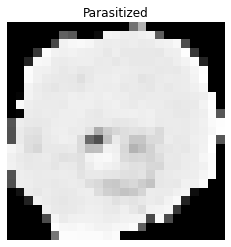

In [5]:
plt.imshow(X[y == 1][0].reshape(25,25), cmap="gray")
plt.axis("off")
plt.title("Parasitized")

Text(0.5, 1.0, 'Not Parasitized')

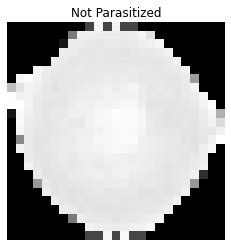

In [6]:
plt.imshow(X[y == 0][0].reshape(25,25), cmap="gray")
plt.axis("off")
plt.title("Not Parasitized")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


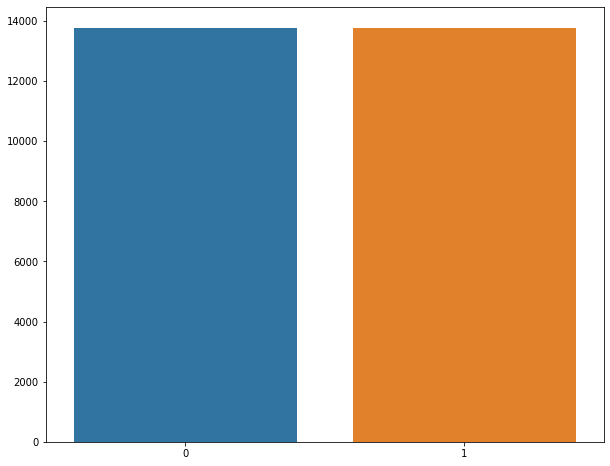

In [7]:
unique, count = np.unique(y, return_counts=True)
plt.figure(figsize=(10,8))
sns.barplot(unique, y=count)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("x_train shape: ",X_train.shape)
print("x_test shape: ",X_test.shape)
print("y_train shape: ",y_train.shape)
print("y_test shape: ",y_test.shape)

x_train shape:  (19290, 625)
x_test shape:  (8268, 625)
y_train shape:  (19290,)
y_test shape:  (8268,)


In [ ]:
# using random forest classifer is like using svm like this: svc_clf = SVC(C=1000, kernel="rbf", gamma=0.1)
# SVM takes a very long time to train and check for cross validation.
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=24, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

In [ ]:
rnd_scores = attrs.cross_val_score(rnd_clf, X_train, y_train, n=15)
attrs.display_cross_val_score(rnd_scores, True, write_path="rnd_cross_val_score.log")

- RandomForest is severly underfitting the dataset

In [ ]:
# let's try ada boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=8), n_estimators=500, algorithm="SAMME.R", random_state=42, learning_rate=0.5)
ada_clf.fit(X_train, y_train)

In [ ]:
# It takes a long period of time!
ada_scores = attrs.cross_val_score(ada_clf, X_train, y_train, n=15)
attrs.display_cross_val_score(ada_scores, True, write_path="ada_cross_val_score.log")

In [ ]:
importlib.reload(attrs)

In [9]:
import xgboost

xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [10]:
xgb_scores = attrs.cross_val_score(xgb_clf, X_train, y_train, n=15)
attrs.display_cross_val_score(xgb_scores, True, write_path="xgb_scores_cross_val_score.log")

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:07:58] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:08:49] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:09:41] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:10:33] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

- AdaBoost and GradientBoost are performing better.
- AdaBoost has **86%** in cross-validation score but **very slow**.
- GradientBoost jas **82%** in cross validation score but **very fast**.

Since both of them have around the same score, let's test both of them on the test case to see which give us a high score.

In [11]:
xgb_test_scores = attrs.cross_val_score(xgb_clf, X_test, y_test, n=10)
attrs.display_cross_val_score(xgb_test_scores, True, write_path="xgb_test_cross_val_score.log")

"""
Scores: [0.77871826 0.80169287 0.80532044 0.80652963 0.808948   0.7980653
 0.79927449 0.7980653  0.7905569  0.79782082]
Mean: 0.7984991992411089
Standard deviation: 0.008283704275120882
"""

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:40:49] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:41:12] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:41:34] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:41:56] WARNING: /mnt/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

Since XgBoost is fast and lightweight, we will stick with it for now.

In [14]:
import joblib

joblib.dump(xgb_clf, "models/xgb_model.pkl")

['models/xgb_model.pkl']